In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image
# import mpldatacursor

from PIL import Image
from PyPDF2 import PdfReader
from matplotlib.widgets import Cursor, SpanSelector

# import pytesseract
import easyocr
import keras_ocr
from keras_ocr.tools import drawAnnotations
import re
import os
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.max_colwidth', None)

### Extracting Images from the PDF

In [ ]:
def extract_images_from_pdf(pdf_path, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the PDF file
    pdf_reader = PdfReader(pdf_path)

    # Loop through each page of the PDF
    for page_number, page in enumerate(pdf_reader.pages):
        # Extract images from the page
        xObject = page['/Resources']['/XObject'].get_object()
        image_counter = 0

        for obj in xObject:
            if xObject[obj]['/Subtype'] == '/Image':
                size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
                data = xObject[obj].get_object()

                if '/Filter' in data:
                    if data['/Filter'] == '/FlateDecode':
                        img = Image.frombytes('RGB', size, data.get_data())
                        img.save(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.png"))
                        image_counter += 1
                    elif data['/Filter'] == '/DCTDecode':
                        img = open(os.path.join(output_folder, f"page_{page_number + 1}_image_{image_counter}.jpg"), "wb")
                        img.write(data.get_data())
                        img.close()
                        image_counter += 1


In [ ]:



current_path=os.getcwd()
pdf_file_path = os.path.join(current_path,"data","Jewelosco.pdf")
output_image_folder_path = os.path.join(current_path,"output")

extract_images_from_pdf(pdf_file_path, output_image_folder_path)

### Displaying the image

In [ ]:
current_path=os.getcwd()
img_path=os.path.join(current_path,"output")
image_files = glob(img_path +'\\*')
# Check if the image file exists
if os.path.exists(image_files[0]):
    # Load the image
    img = Image.open(image_files[0])

    # Create a single subplot for the image
    fig, ax = plt.subplots(figsize=(20, 20))

    # Display the image
    ax.imshow(img)
    ax.set_title(f'Single Image - {os.path.basename(image_files[0])}')
    ax.axis('off')

    # Show the plot
    plt.show()
else:
    print(f"Image not found: {image_files[0]}")

### EasyOCR

In [2]:

image_files = glob('C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output/*')

In [3]:
reader = easyocr.Reader(['en'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


##### Performed some testing and analysis on images

In [4]:
results = reader.readtext(image_files[4])

In [5]:
# Create the DataFrame
bbox_df = pd.DataFrame(results, columns=['bbox', 'text', 'conf'])

In [6]:
# Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
filtered_df = bbox_df[bbox_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]

In [7]:
strings_list = ['digital rebate', 'digital coupon']

# Find the maximum length among the given strings
max_length = max(len(s) for s in strings_list)

In [8]:
# Filter the DataFrame based on the maximum length
filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

In [9]:
filtered_df

,bbox,text,conf
30,"[[603, 437], [671, 437], [671, 449], [603, 449]]",coupon VaRies,0.308107
63,"[[601, 793], [673, 793], [673, 805], [601, 805]]",Coupom VARIES,0.306010


In [10]:
filtered_df.head(100)

,bbox,text,conf
30,"[[603, 437], [671, 437], [671, 449], [603, 449]]",coupon VaRies,0.308107
63,"[[601, 793], [673, 793], [673, 805], [601, 805]]",Coupom VARIES,0.306010


In [11]:
import re
img_id = image_files[4].split('\\')[1]
# Use regular expression to extract the number after "page_"
page_number = re.search(r'page_(\d+)', img_id).group(1)
filtered_df['page_number'] = page_number

In [12]:
image_files[12]

'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output\\page_9_image_0.jpg'

In [ ]:
len(filtered_df['bbox'].values[0])

In [13]:
filtered_df

,bbox,text,conf,page_number
30,"[[603, 437], [671, 437], [671, 449], [603, 449]]",coupon VaRies,0.308107,1
63,"[[601, 793], [673, 793], [673, 805], [601, 805]]",Coupom VARIES,0.306010,1


In [ ]:
# filtered_df_pawan=filtered_df

In [ ]:
# filtered_df_pawan['text']=filtered_df_pawan['text']+filtered_df_pawan['bbox'].astype(str)
# filtered_df_pawan

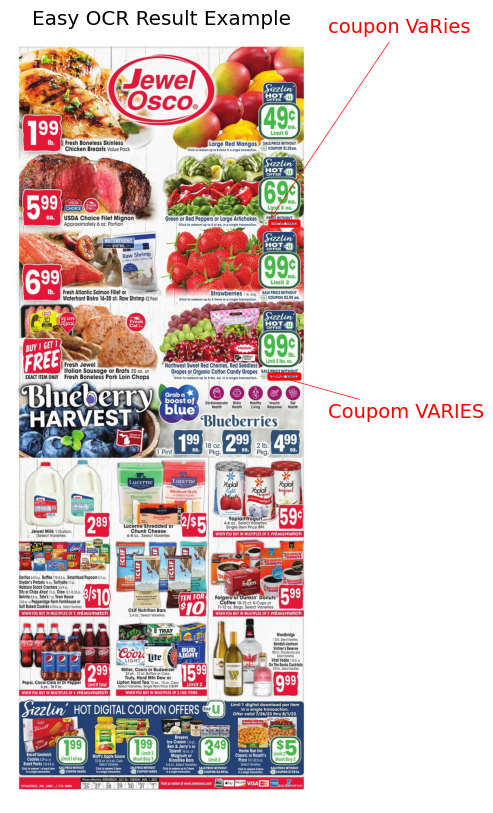

In [14]:
#////////////////////////////////img   
fig, ax = plt.subplots(figsize=(10, 10))

easy_results = filtered_df[['text','bbox']].values.tolist()
# print(easy_results)

easy_results = [(x[0], np.array(x[1])) for x in easy_results]
# print(easy_results)

keras_ocr.tools.drawAnnotations(plt.imread(image_files[4]), easy_results, ax=ax)

ax.set_title('Easy OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output_easy_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()

#### Checking if the strings are close to one another , if yes then merge it
**Calculated the central distance**

In [ ]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [ ]:
filtered_df_copy = filtered_df.copy()

In [ ]:
# Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
grouped_text = []
grouped_conf = []
grouped_indices = []  # To keep track of already grouped indices
group_threshold = 20  # Adjust this threshold as needed based on the data

for idx, row in filtered_df_copy.iterrows():
    if idx in grouped_indices:
        continue  # Skip if the current row is already grouped

    text = row['text']
    conf = row['conf']
    grouped = False

    # Group rows that are close horizontally
    group_rows = [idx]  # List to hold the indices of the grouped rows
    for _, row2 in filtered_df_copy.iterrows():
        if _ == idx or _ in grouped_indices:
            continue  # Skip if the current row is itself or already grouped
        if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
            print(_, idx)
            text += ' ' + row2['text']
            filtered_df_copy.at[idx, 'text'] = text
            filtered_df_copy = filtered_df_copy.drop(_)

            conf = max(conf, row2['conf'])
            filtered_df_copy.at[idx, 'conf'] = conf
            grouped_indices.append(_)
            group_rows.append(_)
            grouped = True

    if grouped:
        grouped_text.append(text)
        grouped_conf.append(conf)
        grouped_indices.append(idx)
        print(grouped_text)
        print(grouped_conf)

grouped_data = {'text': grouped_text, 'conf': grouped_conf}
grouped_df = pd.DataFrame(grouped_data)


In [ ]:
filtered_df_copy

In [ ]:
#////////////////////////////////img   
fig, ax = plt.subplots(figsize=(10, 10))

easy_results = filtered_df_copy[['text','bbox']].values.tolist()
# print(easy_results)

easy_results = [(x[0], np.array(x[1])) for x in easy_results]
# print(easy_results)

keras_ocr.tools.drawAnnotations(plt.imread(image_files[1]), easy_results, ax=ax)

ax.set_title('Easy OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output_easy_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()

In [ ]:
filtered_df_copy

In [ ]:
replace_mapping = {
    'COUPON': 'DIGITAL COUPON',
    'REBATE': 'DIGITAL REBATE',
    'DIghAl COUPON': 'DIGITAL COUPON',
    'DIGgal COUPON': 'DIGITAL COUPON'
}

# Apply the replacements
filtered_df_copy['text'] = filtered_df_copy['text'].replace(replace_mapping)

In [ ]:
filtered_df_copy

In [ ]:
#////////////////////////////////img   
fig, ax = plt.subplots(figsize=(10, 10))

easy_results = filtered_df_copy[['text','bbox']].values.tolist()
# print(easy_results)

easy_results = [(x[0], np.array(x[1])) for x in easy_results]
# print(easy_results)

keras_ocr.tools.drawAnnotations(plt.imread(image_files[1]), easy_results, ax=ax)

ax.set_title('Easy OCR Result Example')

# Save the annotated image with improved quality
output_file = 'C:/Users/pmehra/Desktop/ocr/Adhoc-image-project/output_easy_ocr/annotated_image.jpg'
plt.savefig(output_file, dpi=300)

plt.show()

### For all images using OCR

In [ ]:
import pandas as pd

# Define the functions

# Function to check if the second word is not 'coupon' or 'rebate'
def check_second_word(text):
    words = text.lower().split()
    if len(words)==2:
        return words[1] in ['coupon', 'rebate']
    else:
        return True


def check_length(text):
    w_text = text.lower().split()
    words = max(len('coupon'), len('rebate'), len('digital'))
    # print('Threshold length:',words)
    if len(w_text) == 1:
        # print('Actual Word Length:', len(w_text[0]))
        return len(w_text[0])<=words
    else:
        return True

# Your original code
dfs = []
for img in image_files:
    result = reader.readtext(img)
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])

    # Convert the 'text' column to lowercase and filter rows where the lowercase text starts with the strings
    filtered_df = img_df[img_df['text'].str.lower().str.startswith(('digh', 'reb', 'digital', 'coup', 'dig'), na=False)]
    strings_list = ['digital rebate', 'digital coupon']
    # Find the maximum length among the given strings
    max_length = max(len(s) for s in strings_list)
    # Filter the DataFrame based on the maximum length
    filtered_df = filtered_df[filtered_df['text'].str.len() <= max_length]

    ##Getting the page number
    img_id = img.split('\\')[1]
    page_number = re.search(r'page_(\d+)', img_id).group(1)
    print(page_number)
    filtered_df['page_number'] = page_number

    # Check if each string in the 'text' column has exactly two words
    word_count = filtered_df['text'].str.split().apply(len)
    has_second_string = word_count == 2
    
    # Drop the rows where the 'text' column has more than two words
    filtered_df = filtered_df[~(word_count > 2)]

    if not filtered_df.empty:

        # Filtering out records with "coupon" or "rebate" in the second string
        filtered_df = filtered_df[filtered_df['text'].apply(check_second_word)]
        # Apply the function on 'text_column' and create a boolean mask
        filtered_df = filtered_df[filtered_df['text'].apply(check_length)]

    dfs.append(filtered_df)

easyocr_df = pd.concat(dfs)


In [ ]:
df123 = dfs.copy()

In [ ]:
# df123[1]

In [ ]:
easyocr_df_copy = easyocr_df.copy()

In [ ]:
easyocr_df_copy

In [ ]:
merged_df.head(200)

#### Some comments for Pawan


**Sequence**:

1: Ocr Algo
2. Got all anotations
3. Business rules added
4. Calculating distance of boxes (we have x,y cordinates), algo is already implemented, remove bug and clean it # To do by pawan
5. Makes sure you also have the empty dataframes in the list, such we can keep track of pages
6. Plot all the images, to see the boxes/annotation.
7. Mapping as per below description # To do by pawan
8. Create an aggregated dataframe to show counts. # To do by pawan


Before mapping merge using distance algo

Mapping:

Goal: To create a another data frame

'Digital Coupon' : 'Digital Coupon'
'Coupon' : 'Digital Coupon'
'rebate': 'Digital Rebate'
'DIghAl': 'Digital Coupon'
'DIGgal':'Digital Coupon'	



### Columns
{'Page NO', 'Digital Coupon', 'Digital Rebate'} 

#### Please correct the small glitch in the code  

In [ ]:
def horizontal_distance(bbox1, bbox2):
    x1, y1 = bbox1[0]
    x2, y2 = bbox1[1]
    x3, y3 = bbox2[0]
    x4, y4 = bbox2[1]

    center1_x = (x1 + x2) / 2
    center2_x = (x3 + x4) / 2
    return abs(center1_x - center2_x)

In [ ]:
def merge_logic(df_img):
    # Group bounding boxes that are close horizontally and aggregate the 'text' column as a single string
    grouped_text = []
    grouped_conf = []
    grouped_indices = []  # To keep track of already grouped indices
    group_threshold = 20  # Adjust this threshold as needed based on the data

    for idx, row in df_img.iterrows():
        if idx in grouped_indices:
            continue  # Skip if the current row is already grouped

        text = row['text']
        conf = row['conf']
        grouped = False

        # Group rows that are close horizontally
        group_rows = [idx]  # List to hold the indices of the grouped rows
        for _, row2 in df_img.iterrows():
            if _ == idx or _ in grouped_indices:
                continue  # Skip if the current row is itself or already grouped
            if horizontal_distance(row['bbox'], row2['bbox']) <= group_threshold:
                # print(_, idx)
                text += ' ' + row2['text']
                df_img.at[idx, 'text'] = text
                df_img = df_img.drop(_)

                conf = max(conf, row2['conf'])
                df_img.at[idx, 'conf'] = conf
                grouped_indices.append(_)
                group_rows.append(_)
                grouped = True

        if grouped:
            grouped_text.append(text)
            grouped_conf.append(conf)
            grouped_indices.append(idx)
            # print(grouped_text)
            # print(grouped_conf)
            
    grouped_data = {'text': grouped_text, 'conf': grouped_conf}
    grouped_df = pd.DataFrame(grouped_data)

    return df_img, grouped_df


In [ ]:
df123.

### Look into this and solve it 

In [ ]:
df_report = []
for df in df123:
    if not df.empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        fil_df, grouped_df = merge_logic(df)
        df_report.append(fil_df)
        
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index as the DataFrame is empty.")
        df_report.append(pd.DataFrame())

#### Plot the image

In [ ]:
def plot_compare(img_fn, easyocr_df, count):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    easy_results = easyocr_df[['text','bbox']].values.tolist()
    # print(easy_results)

    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), easy_results, ax=ax)
    ax.set_title('Easy OCR Result Example')

    # Save the annotated image with improved quality
    output_file = f'C:/Users/JubinMohanty/Desktop/OCR_models/data/output_easy_ocr/annotated_image_{count}.jpg'
    plt.savefig(output_file, dpi=300)

    plt.show()

In [ ]:
# df_repor = []
for index, img_path in enumerate(image_files):
    if not df123[index].empty:  # Check if the DataFrame is not empty
        print('Algo has captured the target...')
        print(index)
        plot_compare(img_path, df123[index], index)
        # filtered_df, grouped_df = merge_logic(dfs[index])
        # print(filtered_df)
        # df_report.append(filtered_df)
    else:
        print(f"Skipping index {index} as the DataFrame is empty.")
    # print(index, val)